In [43]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Carpeta root del dataset
image_path = 'BD_perros'

transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Resize((128,128)),
                                ])

dataset = torchvision.datasets.ImageFolder(image_path, transform=transform)

In [44]:
len(dataset)

1030

In [45]:
batch_size = 64

num_datos = len(dataset)
num_train = int(0.7 * num_datos)
num_test = num_datos-num_train

train_dataset = Subset(dataset, torch.arange(num_train))
valid_dataset  = Subset(dataset, torch.arange(num_train, len(dataset)))

train_dl = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
valid_dl = DataLoader(valid_dataset , batch_size= batch_size, shuffle= False)

In [55]:
model = nn.Sequential()

# Conv -> ReLU -> MaxPooling
model.add_module('conv1', nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

# Conv -> ReLU -> MaxPooling
model.add_module('conv2', nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

# Flatten
model.add_module('flatten', nn.Flatten())

# Full Connected -> ReLU -> Dropout
model.add_module('fc1', nn.Linear(200704,1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p= .5))

# Full Connected
model.add_module('fc2', nn.Linear(1024, 5))
#model.add_module('soft', nn.Softmax(dim=10))

In [52]:
1*64*224*224/16

200704.0

In [36]:
# Selección de la unidad de procesamiento
processing_unit = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(processing_unit)
model.to(device)
print(f"You're using: {device} as device.")

You're using: cuda as device.


In [56]:
import torchsummary
torchsummary.summary(model,input_data= torch.randint(0, 255, (batch_size, 3, 224, 224))/ 255,
col_names=["output_size", "num_params"], verbose= 0,device= device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 224, 224]        2,432
├─ReLU: 1-2                              [-1, 32, 224, 224]        --
├─MaxPool2d: 1-3                         [-1, 32, 112, 112]        --
├─Conv2d: 1-4                            [-1, 64, 112, 112]        51,264
├─ReLU: 1-5                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-6                         [-1, 64, 56, 56]          --
├─Flatten: 1-7                           [-1, 200704]              --
├─Linear: 1-8                            [-1, 1024]                205,521,920
├─ReLU: 1-9                              [-1, 1024]                --
├─Dropout: 1-10                          [-1, 1024]                --
├─Linear: 1-11                           [-1, 5]                   5,125
Total params: 205,580,741
Trainable params: 205,580,741
Non-trainable params: 0
Total mult-adds (M): 968.20
Input size (MB): 36.75
Forwa

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= .001)

In [58]:
def train(model, num_epochs, train_dl, valid_dl, device):
    loss_hist_train = torch.zeros(num_epochs).to(device)
    accuracy_hist_train = torch.zeros(num_epochs).to(device)
 
    loss_hist_valid = torch.zeros(num_epochs).to(device)
    accuracy_hist_valid = torch.zeros(num_epochs).to(device)
 
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} 'f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train.cpu(), loss_hist_valid.cpu(), accuracy_hist_train.cpu(), accuracy_hist_valid.cpu()

In [61]:
torch.manual_seed(1)
num_epochs = 10
hist = train(model, num_epochs, train_dl, valid_dl, device)

c:\Users\sfons\anaconda3\envs\ima539\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 accuracy: 0.5062 val_accuracy: 0.0000
Epoch 2 accuracy: 0.5187 val_accuracy: 0.0000
Epoch 3 accuracy: 0.5700 val_accuracy: 0.0000
Epoch 4 accuracy: 0.6047 val_accuracy: 0.0000
Epoch 5 accuracy: 0.5798 val_accuracy: 0.0000
Epoch 6 accuracy: 0.5770 val_accuracy: 0.0000
Epoch 7 accuracy: 0.5839 val_accuracy: 0.0000
Epoch 8 accuracy: 0.6033 val_accuracy: 0.0000
Epoch 9 accuracy: 0.6172 val_accuracy: 0.0000
Epoch 10 accuracy: 0.6449 val_accuracy: 0.0000


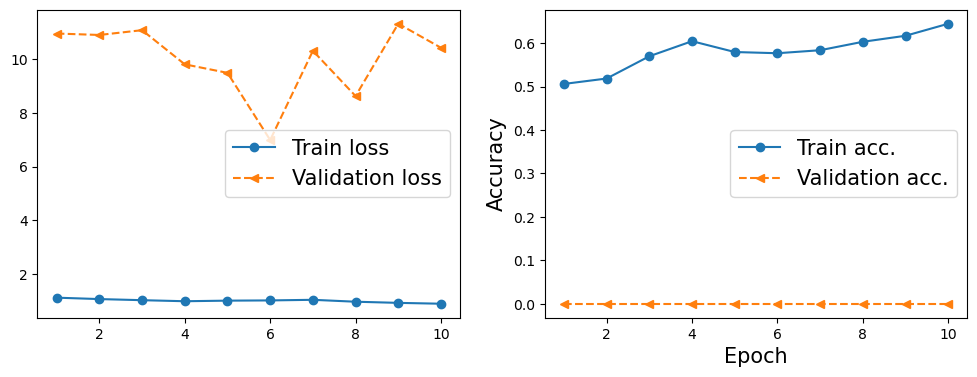

In [62]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize= (12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [31]:
pred = model((test_dataset.data.unsqueeze(1) / 255).to(device))
is_correct = (torch.argmax(pred, dim=1) == test_dataset.targets.to(device)).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

AttributeError: 'DataLoader' object has no attribute 'data'